In [1]:
# Load a model from file
# import joblib
# joblib.load('model_rf_spt.joblib')

# Initialize and define functions

In [36]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

# Define a function to calculate the compressor control voltage (vdc) based on fan speed and power
def compressor_vdc(fan_speed, power, power_low):
    # Initialize the vdc Series with zeros and the same length as fan_speed
    vdc = pd.Series(0, index=fan_speed.index)
    
    # Conditions for calculating vdc
    condition = (fan_speed >= 49) & (power > power_low)
    vdc[condition] = (fan_speed[condition] / 100 + 0.0179) / 0.2073
    
    # Apply maximum limit for vdc
    vdc[vdc > 4.91] = 4.91
    
    # Ensure vdc does not go below 0 (assuming this was meant to apply to vdc, not p, based on context)
    vdc[vdc < 0] = 0
    
    return vdc

# Define a function to calculate the compressor speed ratio based on vdc
def comp_spd_ratio(vdc):
    # Comp Speed Ratio Coefficients (vdc >= 2.42)
    m1 = (1 - 0.317) / (4.91 - 2.42)
    b1 = 0.317 - 2.42 * m1
    # Comp Speed Ratio Coefficients (vdc < 2.42)
    m2 = 0.317 / 2.42
    
    # Initialize y with zeros
    y = pd.Series(0, index=vdc.index)
    
    # Conditions for selecting coefficients
    cond = vdc >= 2.42
    m = pd.Series(m2, index=vdc.index)  # Default to m2
    b = pd.Series(0, index=vdc.index)   # Default to 0
    
    # Update m and b based on condition
    m[cond] = m1
    b[cond] = b1
    
    # Calculate compressor speed ratio
    y = m * vdc + b
    
    return y

# Define a function to calculate accumulated error 
def accumulated_errors(pv, spt, criteria_series, reset_threshold):
    """
    Calculate accumulated errors based on a process variable (pv),
    setpoint (spt), and a criteria series that determines when to reset
    the accumulated error based on the reset threshold.

    Parameters:
    - pv: Pandas Series representing the process variable or temperature.
    - spt: Pandas Series representing the setpoint.
    - criteria_series: Pandas Series representing the criteria for resetting accumulation.
    - reset_threshold: Scalar value that defines the threshold for resetting.

    Returns:
    - Pandas Series representing the accumulated error.
    """
    # Initialize the accumulated error series with the same index as the input series
    acc_errors = pd.Series(0, index=pv.index)
    
    # Initialize a variable to keep track of the current accumulated error
    current_acc_error = 0
    
    # Determine system off state using rolling window
    system_off = criteria_series.rolling(window=15*12, min_periods=1).max() < reset_threshold

    # Iterate through the series by index
    for i in pv.index:
        if system_off[i]:
            # Reset accumulated error to 0 if power is below the threshold
            current_acc_error = 0
            # continue
        else:
            # Calculate the error as the difference between temperature and setpoint
            error = pv[i] - spt[i]
            # Check if adding the error exceeds the max accumulation limit
            if current_acc_error + error > 2500:
                # Here, we set the accumulated error to 3000 if adding the next error would exceed it
                current_acc_error = 2500
            else:
                if error > 0:
                    current_acc_error += error  # Accumulate the error within limit
                else:
                    current_acc_error += error # Reduce the accumulated error at a different rate
        
        # Assign the current accumulated error to the series
        acc_errors[i] = current_acc_error
    
    return acc_errors


# Load data files

In [2]:
# Specify the data folder path
data_folder = 'data/'

# Get a list of all files in the data folder
files = os.listdir(data_folder)

# Print the list of files
print("Available data files:")
for i, file in enumerate(files):
    print(f"{i+1}. {file}")

# Specify the number of the file to load
file_number = 6  # Change this number to load a different file

# Check if the specified file number is valid
if file_number < 1 or file_number > len(files):
    print("Invalid file number. Please choose a valid file number.")
else:
    # Get the file path of the selected file
    file_path = os.path.join(data_folder, files[file_number-1])

Available data files:
1. Test_AtlantaShiftDefault_061623_1055.csv
2. Test_AtlantaSHiftExtSum_07162023_0005.csv
3. Test_AtlantaShiftSTD2019_04092023_2320.csv
4. Test_AtlantaTES_04222023_2302.csv
5. Test_Atlanta_Default_1hr_110123_1357.csv
6. Test_Atlanta_Default_MPC_Pretest_122723_1025.csv
7. Test_Atlanta_Default_random2_102623_2106.csv
8. Test_Atlanta_Default_random_102423_1727.csv
9. Test_Atlanta_Default_Random_102923_1331.csv
10. Test_BuffaloShiftDef_06022023_1805.csv
11. Test_BuffaloShiftDenseOcc_06142023_2109.csv
12. Test_BuffaloShiftExtSum_060323_2005.csv
13. Test_BuffaloShiftSaveBehave_06182023_0242.csv
14. Test_BuffaloShiftSTD2019_060723_1026.csv
15. Test_NewYorkShiftDef_03312023_1837.csv
16. Test_NewYorkShiftDenseOcc_04012023_2115.csv
17. Test_NewYorkShiftSTD2019_05312023_2327.csv
18. Test_TucsonShiftDef_032523_1125.csv
19. Test_TucsonShiftSaveBehav_03282023_2135.csv
20. Test_TusconShiftSTD2019_041123_2101.csv


# Feature analysis
This section analyzes some basic features than is used by a PI controller. It does not aim to identify the best feature sets for the model development.

i: 0, file: Test_AtlantaShiftDefault_061623_1055.csv
Correlation acc_errors: 0.9227
Correlation errors: -0.1476
Correlation errors: -0.0936
Correlation wshp_power: 0.8743
i: 1, file: Test_AtlantaSHiftExtSum_07162023_0005.csv
Correlation acc_errors: 0.8934
Correlation errors: 0.0081
Correlation errors: -0.1136
Correlation wshp_power: 0.9149
i: 2, file: Test_AtlantaShiftSTD2019_04092023_2320.csv
Correlation acc_errors: 0.7857
Correlation errors: 0.0398
Correlation errors: -0.3292
Correlation wshp_power: 0.7531
i: 3, file: Test_AtlantaTES_04222023_2302.csv
Correlation acc_errors: 0.9001
Correlation errors: -0.1720
Correlation errors: -0.3678
Correlation wshp_power: 0.8628
i: 4, file: Test_Atlanta_Default_1hr_110123_1357.csv
Correlation acc_errors: 0.7392
Correlation errors: 0.5412
Correlation errors: 0.1465
Correlation wshp_power: 0.7038
i: 5, file: Test_Atlanta_Default_MPC_Pretest_122723_1025.csv
Correlation acc_errors: 0.9593
Correlation errors: -0.4650
Correlation errors: -0.5036
Corre

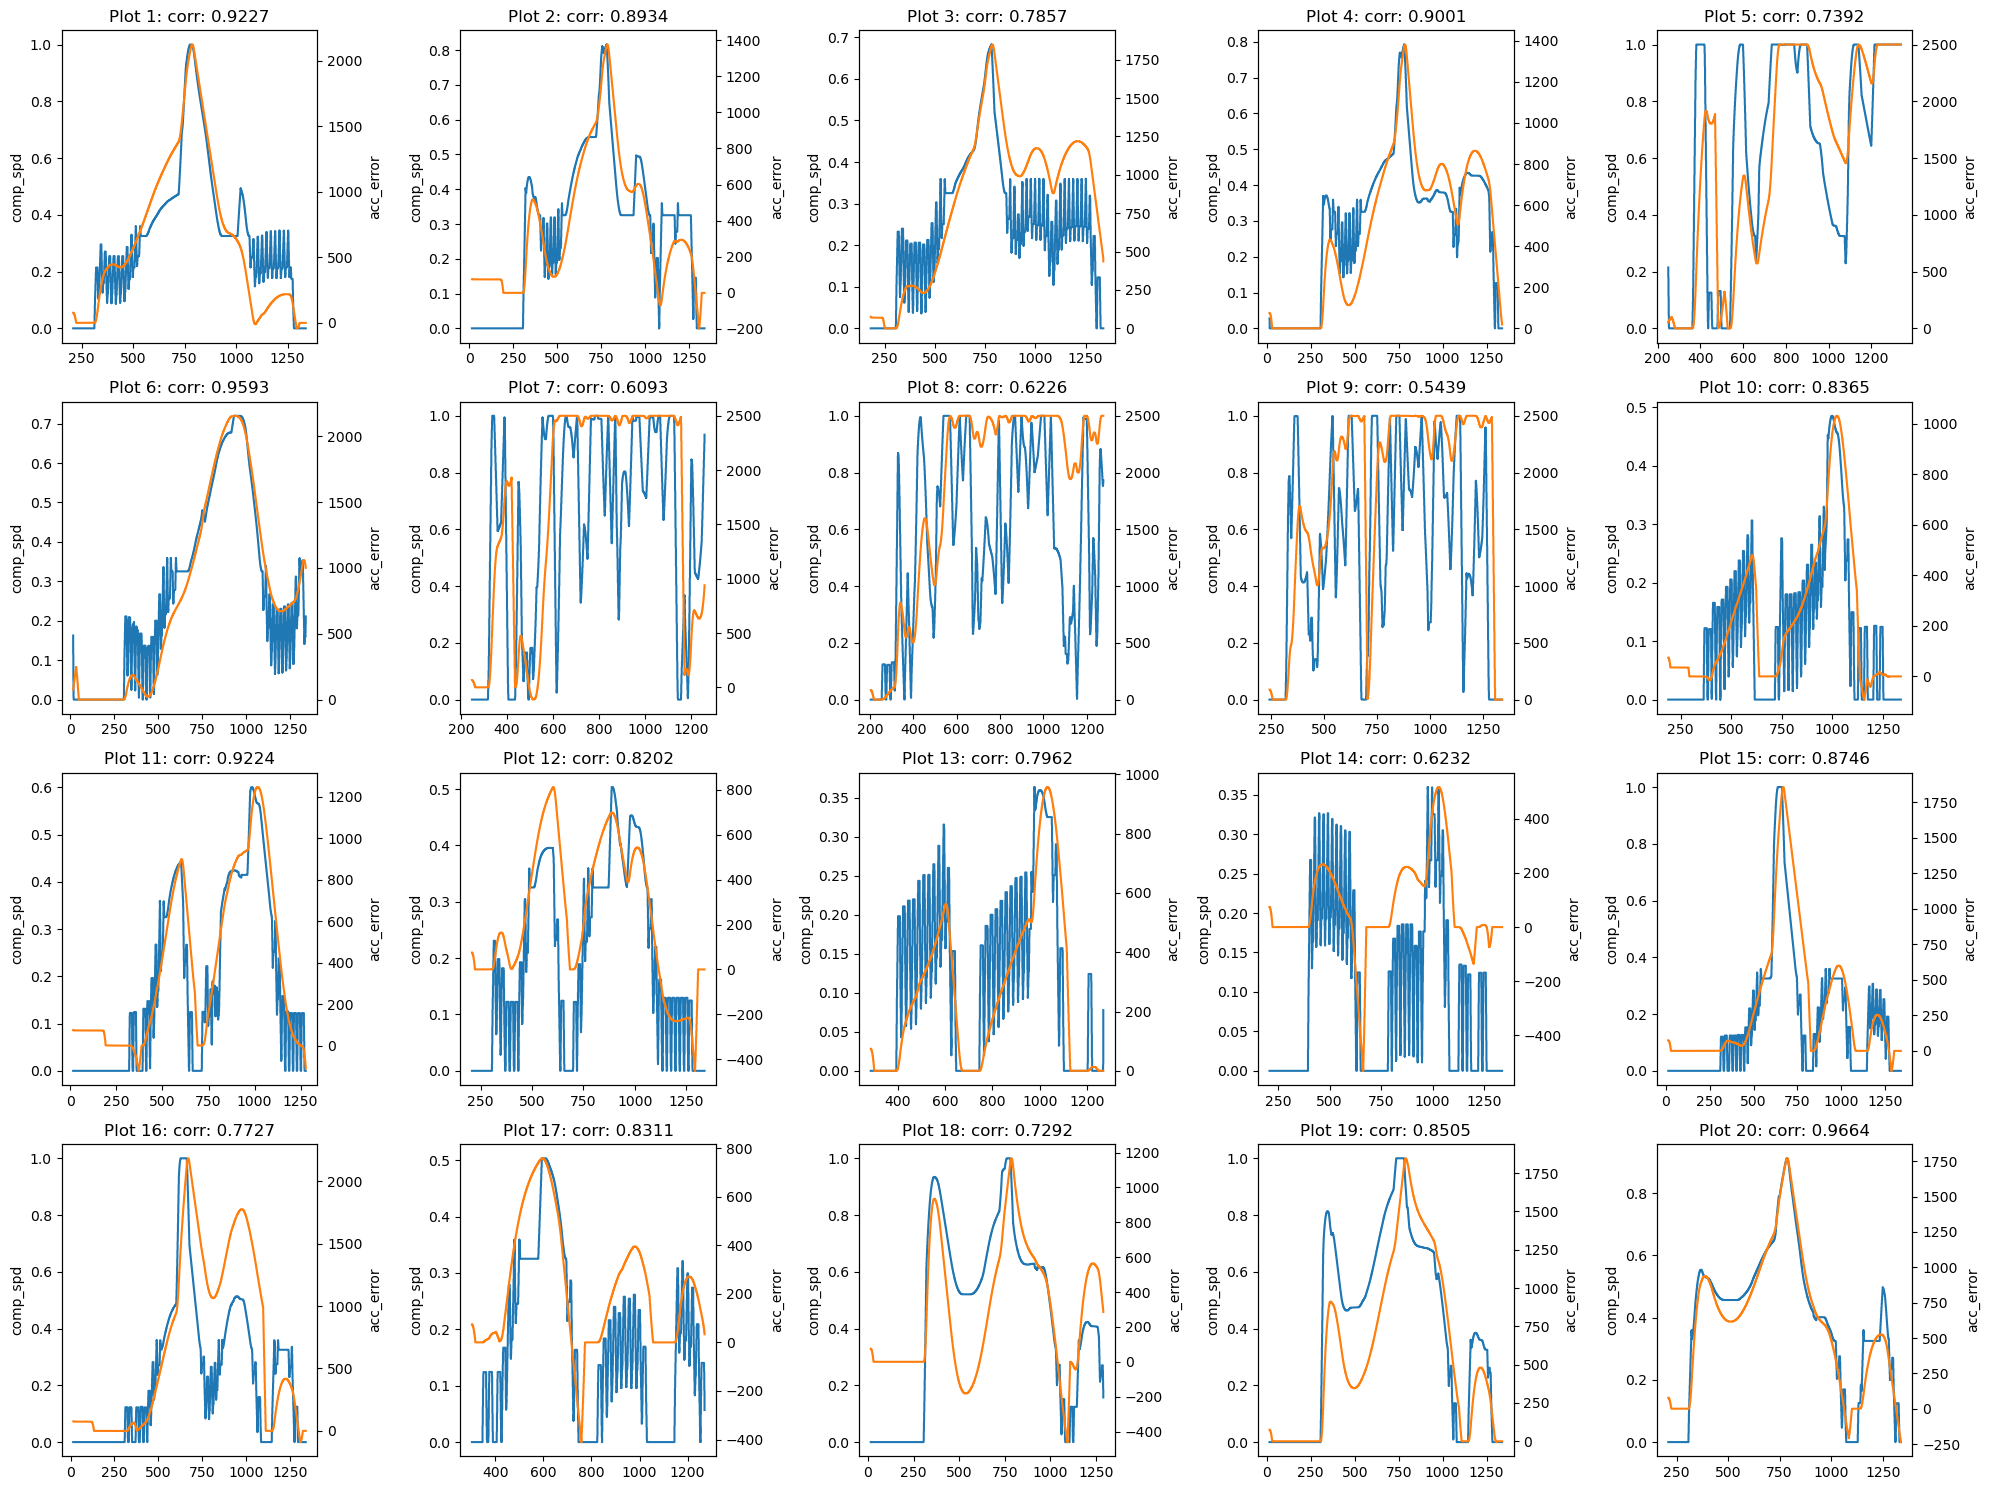

In [37]:
# Initialize empty pandas series to store the results of all iterations
# Data will be used for model training
comp_spd_avg_all_iterations = pd.Series(dtype='float')
acc_errors_avg_all_iterations = pd.Series(dtype='float')
errors_avg_all_iterations = pd.Series(dtype='float')
wshp_power_avg_all_iterations = pd.Series(dtype='float')
sim_zone_temp_avg_all_iterations = pd.Series(dtype='float')
active_setpoint_avg_all_iterations = pd.Series(dtype='float')

# Initialize a dictionary to store the results of each iteration
# Data will be used for verification
results = {}

# Set the subplot layout
n_rows = 4  # Adjust based on the number of plots
n_cols = 5  # Adjust based on the number of plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through the file paths
for i, file in enumerate(files):

    # Get the file path of the selected file
    file_path = os.path.join(data_folder, file)
    print(f"i: {i}, file: {file}")

    # Read the csv file
    data = pd.read_csv(file_path)

    # Remove rows where 'Simulation Time Step' is <= 0 and >=1339
    data = data[data['Simulation Time Step'] > 0]
    data = data[data['Simulation Time Step'] < 1339]
    data = data.reset_index(drop=True)

    # Extract column 'Current Simulation Step'
    simulation_time_step = data['Simulation Time Step']
    # Extract column that contains 'Sim Zone Temp'
    sim_zone_temp = data.filter(like='Sim Zone Temp').iloc[:, 0]
    # Extract column that contains 'Active Setpoint'
    active_setpoint = data.filter(like='Active Setpoint').iloc[:, 0]
    # Extract column that contains 'Fan Speed'
    fan_speed = data.filter(like='Fan Speed').iloc[:, 0]
    # Extract column that contains 'WSHP Power'
    wshp_power = data.filter(like='WSHP Power').iloc[:, 0]
    # Check if 'CompSpd' column exists
    if 'CompSpd' in data.columns:
        # Extract column 'CompSpd'
        vdc_recorded = data['CompSpd']
    else:
        vdc_recorded = None

    # Calculate the error between 'Sim Zone Temp' and 'Active Setpoint'
    errors = sim_zone_temp - active_setpoint

    # Calculate vdc based on fan speed and power
    vdc = compressor_vdc(fan_speed, wshp_power, 150)

    # Calculate the RMSE between vdc and vdc_recorded
    if vdc_recorded is not None:
        rmse = ((vdc - vdc_recorded) ** 2).mean() ** 0.5
        # print(f"RMSE between vdc and vdc_recorded: {rmse:.4f}")

    # Calculatre the compressor speed ratio based on vdc
    comp_spd = comp_spd_ratio(vdc)

    # Calculate min_avg minutes moving average of wshp_power
    min_avg = 15
    wshp_power_avg = wshp_power.rolling(min_avg*12).mean()

    # Calculate the accumulated errors
    criteria_series = wshp_power_avg
    reset_threshold = 150
    acc_errors = accumulated_errors(sim_zone_temp, active_setpoint, criteria_series, reset_threshold)

    # Calculate min_avg minutes moving average of other data
    comp_spd_avg = comp_spd.rolling(min_avg*12).mean()
    acc_errors_avg = acc_errors.rolling(min_avg*12).mean()
    errors_avg = errors.rolling(min_avg*12).mean()
    sim_zone_temp_avg = sim_zone_temp.rolling(min_avg*12).mean()
    active_setpoint_avg = active_setpoint.rolling(min_avg*12).mean()

    # Store the results of each iteration in a dictionary
    results[i] = {'comp_spd_avg': comp_spd_avg, 
                'acc_errors_avg': acc_errors_avg, 
                'errors_avg': errors_avg, 
                'wshp_power_avg': wshp_power_avg, 
                'simulation_time_step': simulation_time_step,
                'sim_zone_temp_avg': sim_zone_temp_avg,
                'active_setpoint_avg': active_setpoint_avg
                }

    # Store part of the data for model development
    if i not in [7, 8]:  

        # Concatenate the results of each iteration to the main Series
        comp_spd_avg_all_iterations = pd.concat([comp_spd_avg_all_iterations, comp_spd_avg], ignore_index=True)
        acc_errors_avg_all_iterations = pd.concat([acc_errors_avg_all_iterations, acc_errors_avg], ignore_index=True)
        errors_avg_all_iterations = pd.concat([errors_avg_all_iterations, errors_avg], ignore_index=True)
        wshp_power_avg_all_iterations = pd.concat([wshp_power_avg_all_iterations, wshp_power_avg], ignore_index=True)
        sim_zone_temp_avg_all_iterations = pd.concat([sim_zone_temp_avg_all_iterations, sim_zone_temp_avg], ignore_index=True)
        active_setpoint_avg_all_iterations = pd.concat([active_setpoint_avg_all_iterations, active_setpoint_avg], ignore_index=True)

    # # Take only the positive part of the accumulated errors
    # acc_errors_avg_pos = acc_errors_avg.copy()
    # acc_errors_avg_pos[acc_errors_avg_pos < 0] = 0

    # Calculate the correlation between the compressor speed ratio and the accumulated errors
    corr = comp_spd_avg.corr(acc_errors_avg)
    print(f"Correlation acc_errors: {corr:.4f}")
    corr = comp_spd_avg.corr(errors_avg)
    print(f"Correlation errors: {corr:.4f}")
    corr = errors_avg.corr(acc_errors_avg)
    print(f"Correlation errors: {corr:.4f}")
    corr = wshp_power_avg.corr(acc_errors_avg)
    print(f"Correlation wshp_power: {corr:.4f}")

    # Switch to make plots for each file
    # if i == 0:

        # # Plot the temperature and setpoint
        # plt.figure()
        # plt.plot(simulation_time_step, sim_zone_temp, label='Sim Zone Temp')
        # plt.plot(simulation_time_step, active_setpoint, label='Active Setpoint')
        # plt.xlabel('Simulation Time Step')
        # plt.ylabel('Temperature')
        # plt.title('Temperature vs. Simulation Time Step')
        # plt.legend()
        # plt.show()

        # # Plot the accumulated errors
        # plt.figure()
        # plt.plot(simulation_time_step, acc_errors)
        # plt.xlabel('Simulation Time Step')
        # plt.ylabel('Accumulated Error')
        # plt.title('Accumulated Error vs. Simulation Time Step')
        # plt.show()

        # # Make a plot to compare vdc and vdc_recorded
        # if vdc_recorded is not None:
        #     plt.figure()
        #     plt.plot(simulation_time_step, vdc, label='vdc')
        #     plt.plot(simulation_time_step, vdc_recorded, label='vdc_recorded')
        #     plt.xlabel('Simulation Time Step')
        #     plt.ylabel('Compressor Control Voltage (Vdc)')
        #     plt.title('Compressor Control Voltage vs. Simulation Time Step')
        #     plt.legend()
        #     plt.show()

        # # Plot the compressor speed ratio
        # plt.figure()
        # plt.plot(simulation_time_step, comp_spd)
        # plt.xlabel('Simulation Time Step')
        # plt.ylabel('Compressor Speed Ratio')
        # plt.title('Compressor Speed Ratio vs. Simulation Time Step')
        # plt.show()

        # # Plot the compressor speed ratio and its moving average
        # plt.figure()
        # plt.plot(simulation_time_step, comp_spd, label='Compressor Speed Ratio')
        # plt.plot(simulation_time_step, comp_spd_avg, label=f'{min_avg} Minute Moving Average')
        # plt.xlabel('Simulation Time Step')
        # plt.ylabel('Compressor Speed Ratio')
        # plt.title('Compressor Speed Ratio vs. Simulation Time Step')
        # plt.legend()
        # plt.show()

        # # Plot the wshp_power and its moving average
        # plt.figure()
        # plt.plot(simulation_time_step, wshp_power, label='WSHP Power')
        # plt.plot(simulation_time_step, wshp_power_avg, label=f'{min_avg} Minute Moving Average')
        # plt.xlabel('Simulation Time Step')
        # plt.ylabel('WSHP Power')
        # plt.title('WSHP Power vs. Simulation Time Step')
        # plt.legend()
        # plt.show()

        # # Plot the accumulated errors and its moving average
        # plt.figure()
        # plt.plot(simulation_time_step, acc_errors, label='Accumulated Error')
        # plt.plot(simulation_time_step, acc_errors_avg, label=f'{min_avg} Minute Moving Average')
        # plt.xlabel('Simulation Time Step')
        # plt.ylabel('Accumulated Error')
        # plt.title('Accumulated Error vs. Simulation Time Step')
        # plt.legend()
        # plt.show()

        # # Plot the errors and its moving average
        # plt.figure()
        # plt.plot(simulation_time_step, errors, label='Errors')
        # plt.plot(simulation_time_step, errors_avg, label=f'{min_avg} Minute Moving Average')
        # plt.xlabel('Simulation Time Step')
        # plt.ylabel('Errors')
        # plt.title('Errors vs. Simulation Time Step')
        # plt.legend()
        # plt.show()

        # # Make a plot to find out the correlation between wsph_power and acc_errors
        # plt.figure()
        # plt.scatter(acc_errors, wshp_power)
        # plt.xlabel('Accumulated Error')
        # plt.ylabel('WSHP Power')
        # plt.title('WSHP Power vs. Accumulated Error')
        # plt.show()

        # # Plot the wshp_power_avg and acc_errors_avg, using two different y-axes
        # fig, ax1 = plt.subplots()
        # ax2 = ax1.twinx()
        # ax1.plot(simulation_time_step, wshp_power_avg, 'g-')
        # ax2.plot(simulation_time_step, acc_errors_avg, 'b-')
        # ax1.set_xlabel('Simulation Time Step')
        # ax1.set_ylabel('WSHP Power', color='g')
        # ax2.set_ylabel('Accumulated Error', color='b')
        # plt.title('WSHP Power and Accumulated Error vs. Simulation Time Step')
        # plt.show()

    # Normalized wshp_power_avg and acc_errors_avg
    wshp_power_avg_norm = (wshp_power_avg - wshp_power_avg.mean()) / wshp_power_avg.std()
    acc_errors_avg_norm = (acc_errors_avg - acc_errors_avg.mean()) / acc_errors_avg.std()
    
    
    # Assign values to y1 and y2
    # y1 = wshp_power_avg_norm; y1_label = 'pwr'
    # y2 = acc_errors_avg_norm; y2_label = 'acc_error'
    # title = 'pwr vs acc_error'
    # corr = wshp_power_avg.corr(acc_errors_avg)
    # y1 = wshp_power_avg; y1_label = 'pwr'
    # y2 = acc_errors_avg; y2_label = 'acc_error'
    # title = 'pwr vs acc_error'
    y1 = comp_spd_avg; y1_label = 'comp_spd'
    y2 = acc_errors_avg; y2_label = 'acc_error'
    title = 'comp_spd vs acc_error'
    corr = comp_spd_avg.corr(acc_errors_avg)
    # y1 = sim_zone_temp_avg; y1_label = 'sim_zone_temp'
    # y2 = active_setpoint_avg; y2_label = 'active_setpoint'
    # title = 'sim_zone_temp vs active_setpoint'

    # Get the current color cycle
    current_cycler = plt.rcParams['axes.prop_cycle']
    colors = current_cycler.by_key()['color']

    # Two y-axes plot
    ax = axes[i]
    ax2 = ax.twinx()
    ax.plot(simulation_time_step, y1, color=colors[0])
    ax2.plot(simulation_time_step, y2, color=colors[1])
    ax.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    ax.set_title(f'Plot {i+1}: corr: {corr:.4f}')

    # ax = axes[i]
    # ax.plot(simulation_time_step, y1, color=colors[0], label=y1_label)
    # ax.plot(simulation_time_step, y2, color=colors[1], label=y2_label)
    # ax.set_title(f'Plot {i+1}: corr: {corr:.4f}')
    # ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Power model development
This model is ideal for a virutal testbed, where computational cost is not a major concern.
For ideal MPC implementation, polynomial models may be the best, however, they have poor accuracy for the nonlinearity that we are dealing with here. 

## Data preperation and model selection

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Combine errors_avg, acc_errors_avg, and comp_spd_avg into a single DataFrame and provide column names
df = pd.DataFrame({'errors': errors_avg_all_iterations, 'acc_errors': acc_errors_avg_all_iterations, 'comp_spd': comp_spd_avg_all_iterations, 'wshp_power': wshp_power_avg_all_iterations})

# Drop rows with null values
df = df.dropna()

# Split the data into features (X) and target variable (y)
X = df[['acc_errors', 'errors']]
y = df['wshp_power']

# Model selection
# model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),
#                            LinearRegression(fit_intercept=True))
model = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
# model = MLPRegressor(random_state=0)

## Model validation

### k-fold validation

In [ ]:
# Perform k-fold cross-validation using RMSE
rmse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

# Print the RMSE scores and their average
print(f"RMSE scores: {-rmse_scores}")
print(f"Average RMSE: {np.mean(-rmse_scores)}")

RMSE scores: [315.07872574 407.08289826 329.37815347 288.64123746 501.73259426]
Average RMSE: 368.3827218384195


### Manual split

In [ ]:
# Validation using the manual split
for i in [3, 676, 56, 2132, 23]:

    # Mannually split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions using two sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate the RMSE of the model
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f"RMSE of training set: {rmse_train:.4f}")
    print(f"RMSE of testing set: {rmse_test:.4f}")

RMSE of training set: 43.8097
RMSE of testing set: 117.9812
RMSE of training set: 43.9980
RMSE of testing set: 117.0600
RMSE of training set: 43.9803
RMSE of testing set: 116.6838
RMSE of training set: 43.9800
RMSE of testing set: 116.3507
RMSE of training set: 43.8906
RMSE of testing set: 118.0942


## Model training

In [ ]:
# Train the model on the entire dataset
model.fit(X, y)

# Print the OOB score
print(f"OOB Score (R^2): {model.oob_score_}")

# Save the model to a file
import joblib
joblib.dump(model, 'model_rf_pwr.joblib')

OOB Score (R^2): 0.9454707182340789


['model_rf_pwr.joblib']

## Verification

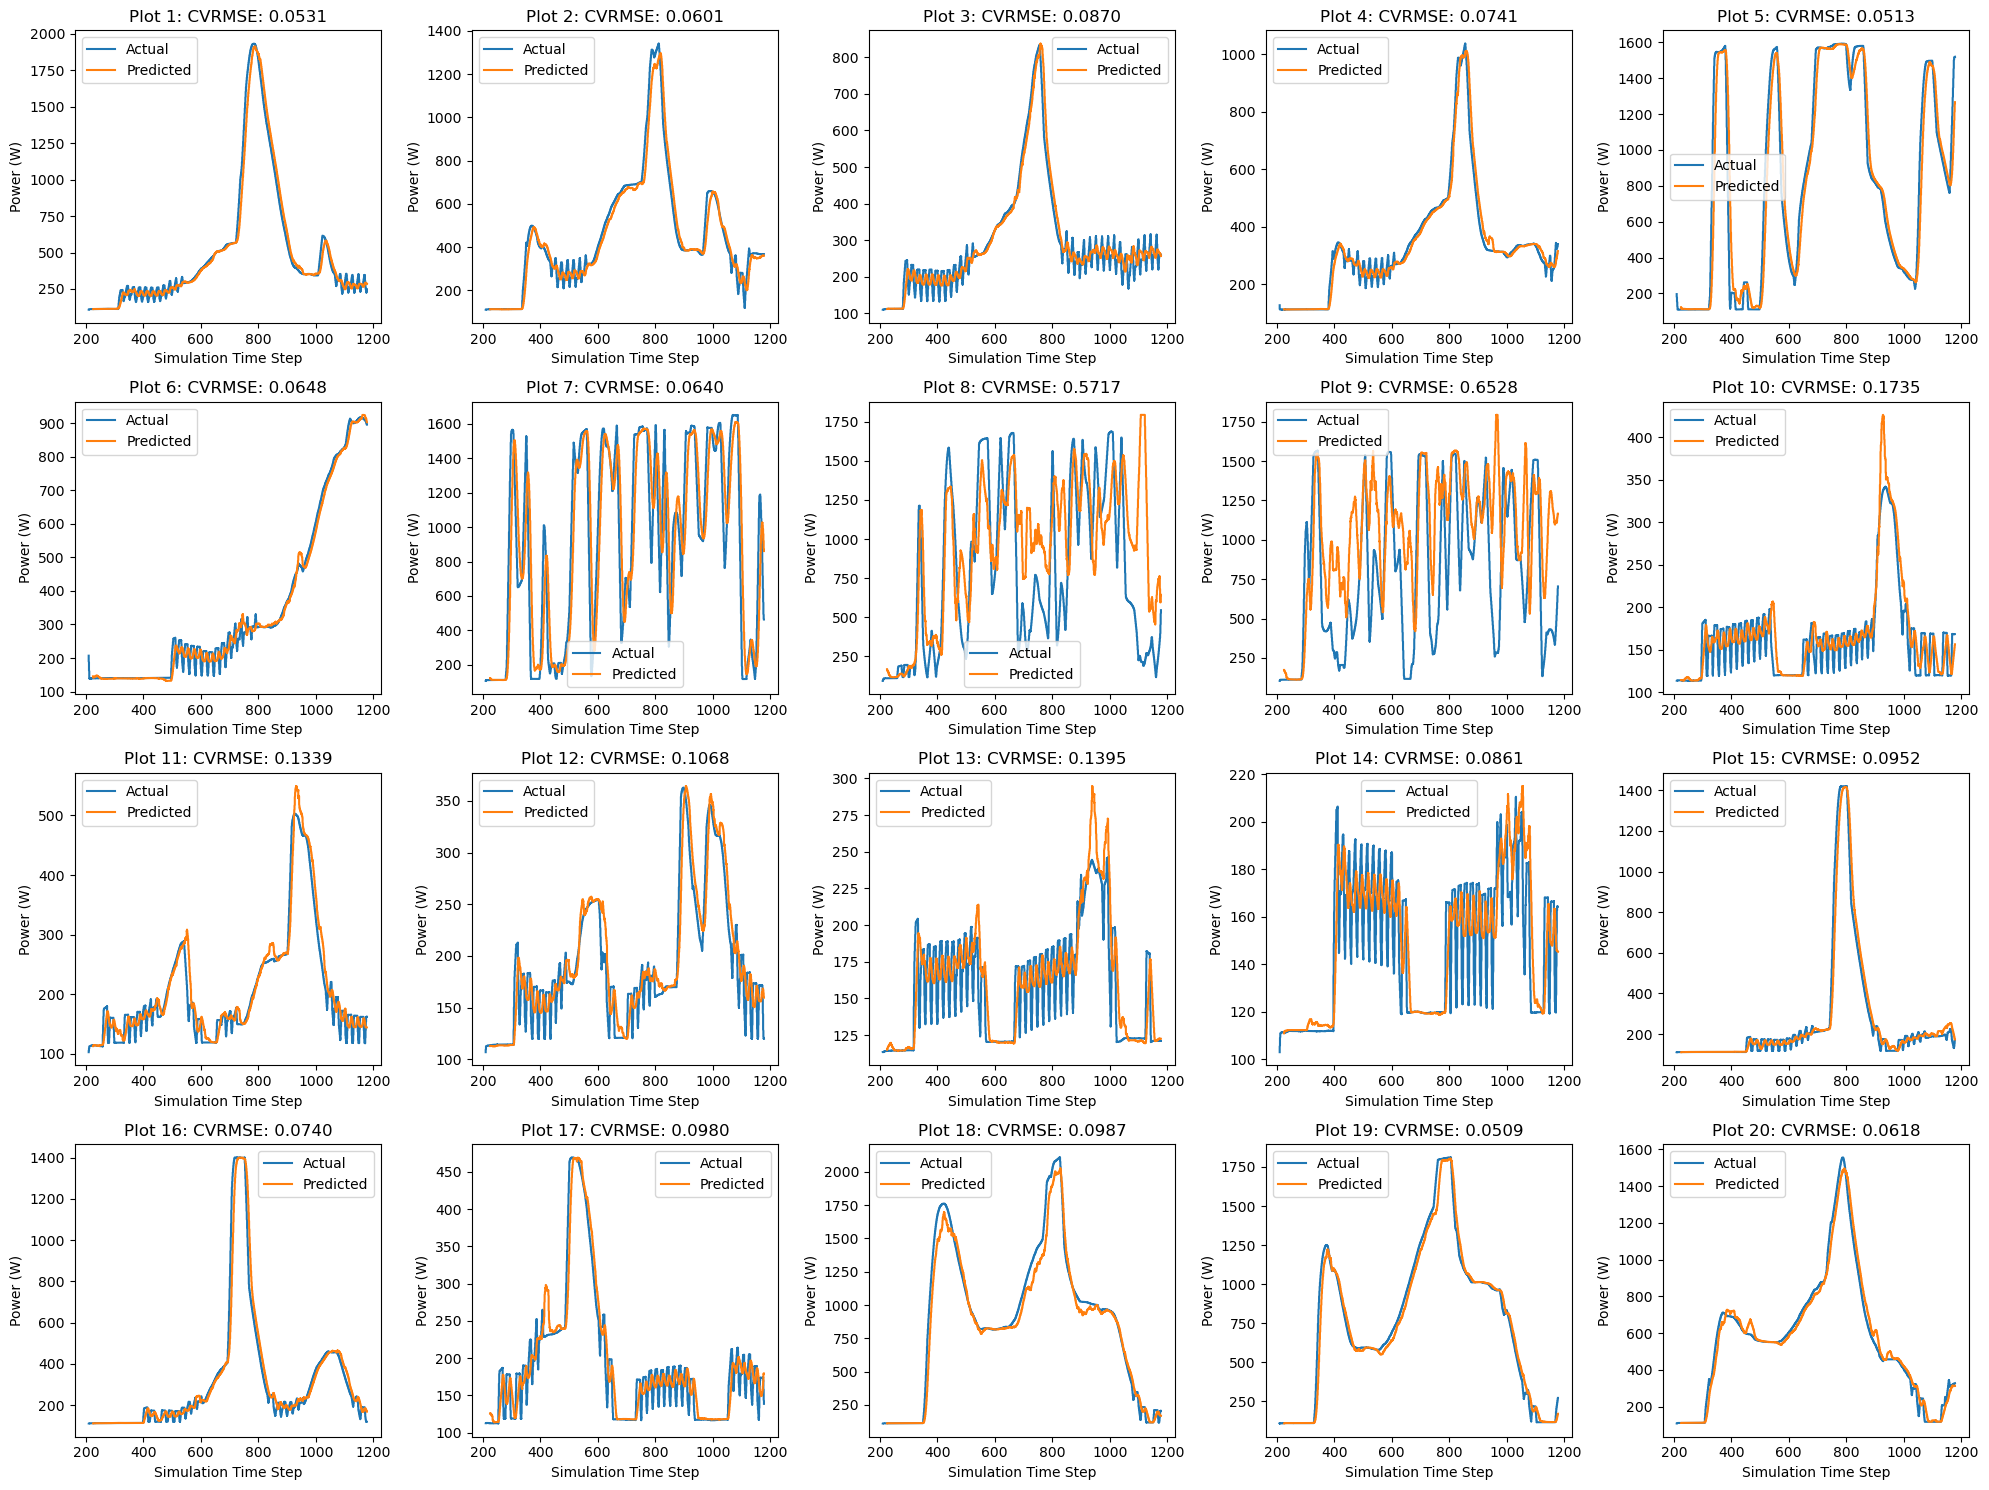

In [ ]:
# Set the subplot layout
n_rows = 4  # Adjust based on the number of plots
n_cols = 5  # Adjust based on the number of plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through the file paths
for i, file in enumerate(files):

    # Extract the series directly from the dictionary
    comp_spd_avg_temp = results[i]['comp_spd_avg']
    acc_errors_avg_temp = results[i]['acc_errors_avg']
    errors_avg_temp = results[i]['errors_avg']
    wshp_power_avg_temp = results[i]['wshp_power_avg']
    simulation_time_step_temp = results[i]['simulation_time_step']

    # Combine the series into a single DataFrame
    df = pd.DataFrame({
        'comp_spd': comp_spd_avg_temp,
        'acc_errors': acc_errors_avg_temp,
        'errors': errors_avg_temp,
        'wshp_power': wshp_power_avg_temp,
        'simulation_time_step': simulation_time_step
    })

    # Drop rows with null values
    df = df.dropna()

    # Set the whole row to zero if any value in the row is NaN
    # df = df.fillna(0)

    # Assemble the feature space
    X = df[['acc_errors', 'errors']]
    # X = df[['acc_errors']]

    # Assemble the target variable
    # y_actual = df['comp_spd']
    y_actual = df['wshp_power']

    # Predict the target variable
    y_pred = model.predict(X)

    # Calculate the moving average of the predicted values
    min_avg = 15
    y_pred_avg = pd.Series(y_pred).rolling(min_avg*12).mean()

    # Calculate the RMSE between the actual and predicted compressor speed ratio
    mse = mean_squared_error(y_actual, y_pred)
    rmse = mse ** 0.5
    cvrmse = rmse / y_actual.mean()
    # print(f"RMSE: {rmse:.4f}")

    # Plot the actual and predicted values
    simulation_time_step = df['simulation_time_step']
    ax = axes[i]
    ax.plot(simulation_time_step, y_actual, label='Actual')
    ax.plot(simulation_time_step, y_pred_avg, label='Predicted')
    ax.set_xlabel('Simulation Time Step')
    ax.set_ylabel('Power (W)')
    ax.set_title(f'Plot {i+1}: CVRMSE: {cvrmse:.4f}')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()




# Temperature setpoint (or error) model development
Instead of a model for direct power prediction within the MPC, the model here resides after the MPC output (either the power or compressor speed). The goal here is to decide the temperature setpoint to achieve the MPC output in reality.

## Data preperation and model selection

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Combine errors_avg, acc_errors_avg, and comp_spd_avg into a single DataFrame and provide column names
df = pd.DataFrame({'errors': errors_avg_all_iterations, 
                   'acc_errors': acc_errors_avg_all_iterations, 
                   'comp_spd': comp_spd_avg_all_iterations, 
                   'wshp_power': wshp_power_avg_all_iterations,
                   'sim_zone_temp': sim_zone_temp_avg_all_iterations,
                   'active_setpoint': active_setpoint_avg_all_iterations})

# Drop rows with null values
df = df.dropna()

# Split the data into features (X) and target variable (y)
# X = df[['acc_errors', 'wshp_power']]
# y = df['errors']
X = df[['sim_zone_temp', 'wshp_power']]
y = df['active_setpoint']

# Model selection
# model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),
#                            LinearRegression(fit_intercept=True))
model = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
# model = MLPRegressor(random_state=0)


## Model validation

### k-fold validation

In [ ]:

# Perform k-fold cross-validation using RMSE
rmse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

# Print the RMSE scores and their average
print(f"RMSE scores: {-rmse_scores}")
print(f"Average RMSE: {np.mean(-rmse_scores)}")

RMSE scores: [0.86614348 1.12347688 0.78656366 0.62893237 1.61665927]
Average RMSE: 1.0043551329777953


### Manual split

In [ ]:
# Validation with manual split
for i in [3, 676, 56, 2132, 23]:

    # Mannually split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions using two sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate the RMSE of the model
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f"RMSE of training set: {rmse_train:.4f}")
    print(f"RMSE of testing set: {rmse_test:.4f}")

RMSE of training set: 0.1318
RMSE of testing set: 0.3491
RMSE of training set: 0.1312
RMSE of testing set: 0.3518
RMSE of training set: 0.1309
RMSE of testing set: 0.3541
RMSE of training set: 0.1305
RMSE of testing set: 0.3549
RMSE of training set: 0.1319
RMSE of testing set: 0.3463


## Model training

In [ ]:
# Train the model on the entire dataset
model.fit(X, y)

# Print the OOB score
print(f"OOB Score (R^2): {model.oob_score_}")

# Save the model to a file
import joblib
joblib.dump(model, 'model_rf_spt.joblib')

OOB Score (R^2): 0.9389887351704101


['model_rf_spt.joblib']

## Verification

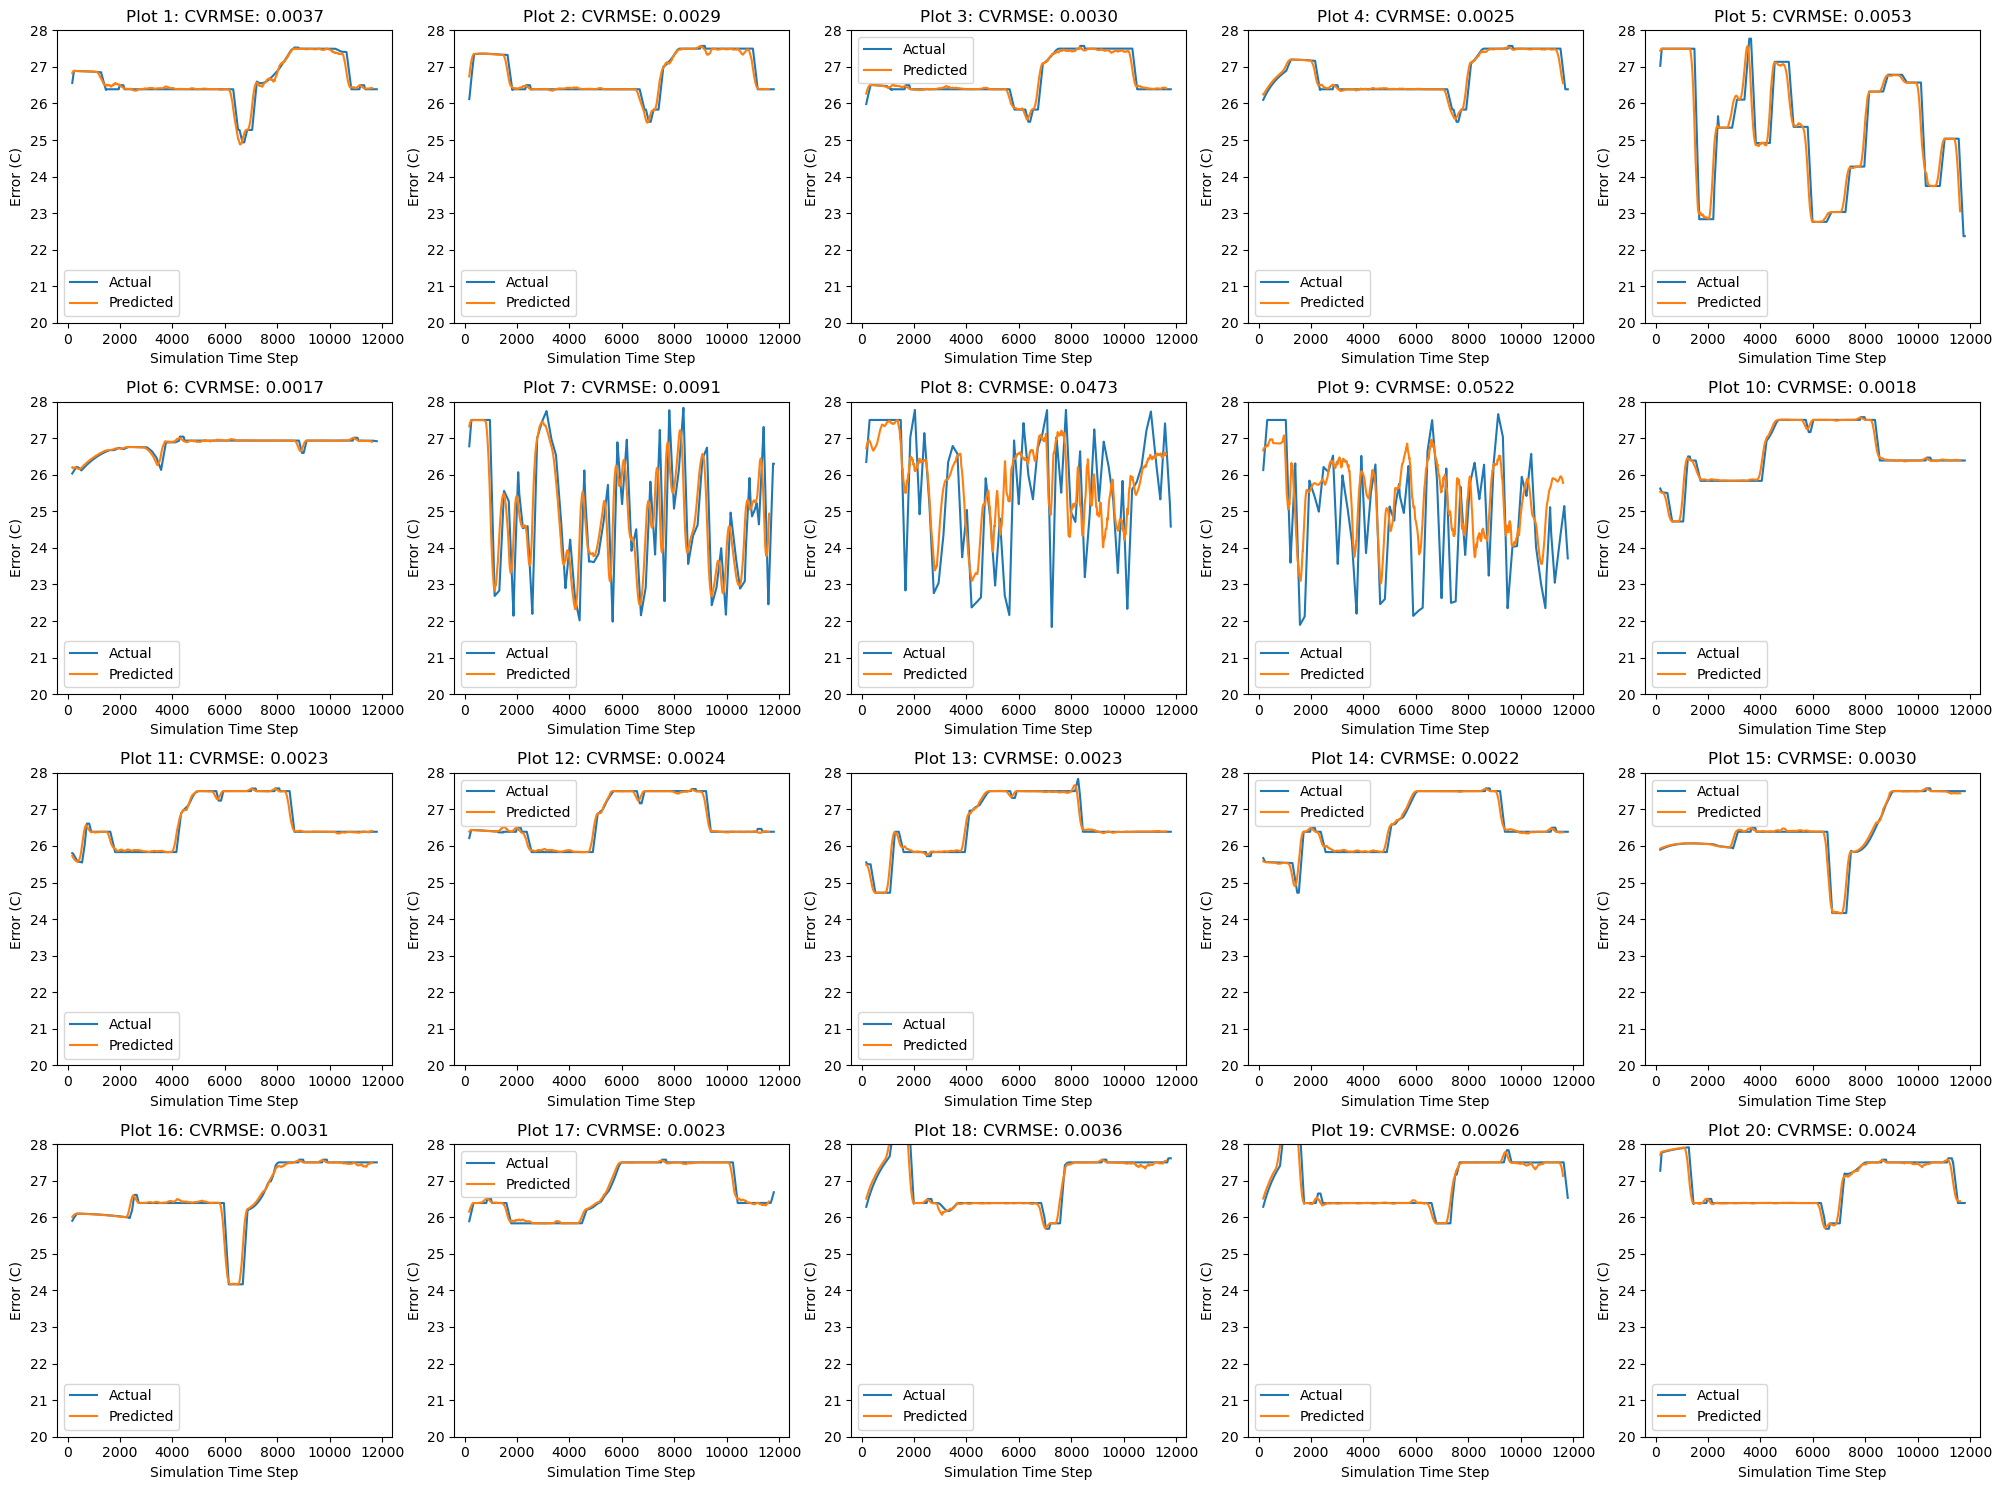

In [ ]:
# Set the subplot layout
n_rows = 4  # Adjust based on the number of plots
n_cols = 5  # Adjust based on the number of plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through the file paths
for i, file in enumerate(files):

    # Extract the series directly from the dictionary
    comp_spd_avg_temp = results[i]['comp_spd_avg']
    acc_errors_avg_temp = results[i]['acc_errors_avg']
    errors_avg_temp = results[i]['errors_avg']
    wshp_power_avg_temp = results[i]['wshp_power_avg']
    simulation_time_step_temp = results[i]['simulation_time_step']
    sim_zone_temp_avg_temp = results[i]['sim_zone_temp_avg']
    active_setpoint_avg_temp = results[i]['active_setpoint_avg']

    # Combine the series into a single DataFrame
    df = pd.DataFrame({
        'comp_spd': comp_spd_avg_temp,
        'acc_errors': acc_errors_avg_temp,
        'errors': errors_avg_temp,
        'wshp_power': wshp_power_avg_temp,
        'simulation_time_step': simulation_time_step,
        'sim_zone_temp': sim_zone_temp_avg_temp,
        'active_setpoint': active_setpoint_avg_temp
    })

    # Drop rows with null values
    df = df.dropna()

    # Set the whole row to zero if any value in the row is NaN
    # df = df.fillna(0)

    # Assemble the feature space
    # X = df[['acc_errors', 'wshp_power']]
    X = df[['sim_zone_temp', 'wshp_power']]
    # X = df[['acc_errors']]

    # Assemble the target variable
    # y_actual = df['comp_spd']
    # y_actual = df['errors']
    y_actual = df['active_setpoint']

    # Predict the target variable
    y_pred = model.predict(X)
    # y_pred = df['sim_zone_temp']-y_pred

    # Calculate the moving average of the predicted values
    min_avg = 15
    y_pred_avg = pd.Series(y_pred).rolling(min_avg*12).mean()

    # Calculate the RMSE between the actual and predicted compressor speed ratio
    mse = mean_squared_error(y_actual, y_pred)
    rmse = mse ** 0.5
    cvrmse = rmse / y_actual.mean()

    # # Plot the actual and predicted values
    # simulation_time_step = df['simulation_time_step']
    # plt.figure()
    # plt.scatter(simulation_time_step, y_actual, label='Actual', marker='o')
    # plt.scatter(simulation_time_step, y_pred_avg, label='Predicted', marker='x')
    # plt.xlabel('Simulation Time Step')
    # plt.ylabel('Error')
    # plt.title('Actual vs. Predicted Error')
    # plt.text(x=0.05, y=0.85, s=f'RMSE: {rmse:.3f}', ha='left', va='top', transform=plt.gca().transAxes)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()
    # Plotting in the specified subplot
    simulation_time_step = df['simulation_time_step']
    ax = axes[i]
    ax.plot(y_actual, label='Actual')
    ax.plot(y_pred_avg, label='Predicted')
    ax.set_xlabel('Simulation Time Step')
    ax.set_ylabel('Error (C)')
    ax.set_title(f'Plot {i+1}: CVRMSE: {cvrmse:.4f}')
    ax.legend()
    ax.set_ylim(20, 28)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
